In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,classification_report,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn_pandas import DataFrameMapper
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

heart_disease = fetch_ucirepo(id=45) 
  
# Carga de las variables y la variable objetivo como dataframes 
X = heart_disease.data.features 
y = heart_disease.data.targets 


In [2]:
# información de las variables
heart_disease.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


In [3]:
# comprobación rápida de la estructura de las variables independientes
X.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [4]:
# comprobación rápida de la estructura de la variable objetivo
y.head(5)

,num
0,0
1,2
2,1
3,0
4,0


In [5]:
# comprobación de si hay valores faltantes en las variables independientes
missing_features_index=X[X.isna().any(axis=1)].index
missing_features_index

Index([87, 166, 192, 266, 287, 302], dtype='int64')

In [6]:
# como hay valores faltantes, eliminamos las filas en los 2 df
X.drop(missing_features_index, inplace=True)
y.drop(missing_features_index, inplace=True)

C:\Users\Erik\AppData\Local\Temp\ipykernel_55884\1907183801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(missing_features_index, inplace=True)
C:\Users\Erik\AppData\Local\Temp\ipykernel_55884\1907183801.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop(missing_features_index, inplace=True)


In [7]:
# dado que la prueba solo requiere analizar si hay enfermedad o no, transformamos la objetivo a una binaria y comprobamos que haya funcionado
y[y!=0]=1
y['num'].unique()

C:\Users\Erik\AppData\Local\Temp\ipykernel_55884\3296462517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y!=0]=1
C:\Users\Erik\AppData\Local\Temp\ipykernel_55884\3296462517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y!=0]=1


array([0, 1], dtype=int64)

In [8]:
# las variables númericas requieren ser estandarizadas
mapper_df = DataFrameMapper([(['age','trestbps','chol','thalach','oldpeak','ca'], StandardScaler()),(['sex','cp','fbs','restecg','exang','slope','thal'],None)], df_out=True)
X=mapper_df.fit_transform(X.copy())
X.columns=['age','trestbps','chol','thalach','oldpeak','ca','sex','cp','fbs','restecg','exang','slope','thal']
X.head(5)

,age,trestbps,chol,thalach,oldpeak,ca,sex,cp,fbs,restecg,exang,slope,thal
0,0.936181,0.750380,-0.276443,0.017494,1.068965,-0.721976,1.0,1.0,1.0,2.0,0.0,3.0,6.0
1,1.378929,1.596266,0.744555,-1.816334,0.381773,2.478425,1.0,4.0,0.0,2.0,1.0,2.0,3.0
2,1.378929,-0.659431,-0.353500,-0.899420,1.326662,1.411625,1.0,4.0,0.0,2.0,1.0,2.0,7.0
3,-1.941680,-0.095506,0.051047,1.633010,2.099753,-0.721976,1.0,3.0,0.0,0.0,0.0,3.0,3.0
4,-1.498933,-0.095506,-0.835103,0.978071,0.295874,-0.721976,0.0,2.0,0.0,2.0,0.0,1.0,3.0


In [9]:
# partición del dataset para hacer pruebas de evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y['num'], test_size=0.20, random_state = 1)

In [10]:
# comproación de que los datos no estén desbalanceados
Counter(y_train)

Counter({0: 130, 1: 107})

In [11]:
# modelo de regresión logística y medidas de validación
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)

In [12]:
print("Matriz de confusion")
print(lr_conf_matrix)
print("Accuracy of Logistic Regression:",lr_acc_score)
print(classification_report(y_test,lr_predict))

Matriz de confusion
[[23  7]
 [ 4 26]]
Accuracy of Logistic Regression: 0.8166666666666667
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        30
           1       0.79      0.87      0.83        30

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60



In [13]:
# modelo de naive bayes y medidas de validación
nb = GaussianNB()
nb.fit(X_train,y_train)
nbpred = nb.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_acc_score = accuracy_score(y_test, nbpred)

In [14]:
print("Matriz de confusion")
print(nb_conf_matrix)
print("Accuracy of Naive Bayes model:",nb_acc_score)
print(classification_report(y_test,nbpred))

Matriz de confusion
[[27  3]
 [ 4 26]]
Accuracy of Naive Bayes model: 0.8833333333333333
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.90      0.87      0.88        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [15]:
# grid search para los hiperparámetros de random forest
gs_rf = GridSearchCV(
    RandomForestClassifier(random_state=1),
    param_grid={"n_estimators": range(100, 2002, 100),"max_depth":[2,5,7]},
    scoring='roc_auc',
    n_jobs=-2, cv=10
)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=1), n_jobs=-2,
             param_grid={'max_depth': [2, 5, 7],
                         'n_estimators': range(100, 2002, 100)},
             scoring='roc_auc')

In [16]:
# modelo de random forest y medidas de validación
rf = RandomForestClassifier(random_state=1)
rf.set_params(**gs_rf.best_params_)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)

In [17]:
print("Matriz de confusion")
print(rf_conf_matrix)
print("Accuracy of Random Forest:",rf_acc_score)
print(classification_report(y_test,rf_predicted))

Matriz de confusion
[[27  3]
 [ 5 25]]
Accuracy of Random Forest: 0.8666666666666667
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.89      0.83      0.86        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



In [18]:
# grid search para los hiperparámetros de extreme gradient boosting
parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.05,0.1,0.01], 
              'max_depth': [5,7,10,12,15],
              'min_child_weight': [1,5,10],
              'subsample': [0.7],
              'n_estimators':[10,80,200,500,1000,2000],
              'seed': [1]}

gs_xgb = GridSearchCV(XGBClassifier(), parameters, n_jobs=-2, cv=10, scoring='roc_auc')
gs_xgb.fit(X_train, y_train)

c:\Users\Erik\Documents\Python\.venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Erik\Documents\Python\.venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Erik\Documents\Python\.venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Erik\Documents\Python\.venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_b

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-2,
             param_grid={'learning_rate': [0.05, 0.1, 0.01],
                         'max_depth': [5, 7, 10, 12, 15],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [10, 80, 200, 500, 1000, 2000],
                         'nthread': [4], 'objective': ['binary:logistic'],
                         'seed': [1], 'subsample': [0.7]},
             scoring='roc_auc')

In [19]:
# modelo de extreme gradient boosting y medidas de validación
xgb = XGBClassifier(seed=1)
xgb.set_params(**gs_xgb.best_params_)
xgb.fit(X_train, y_train)
xgb_predicted = xgb.predict(X_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)

c:\Users\Erik\Documents\Python\.venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Erik\Documents\Python\.venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Erik\Documents\Python\.venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Erik\Documents\Python\.venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_b

In [20]:
print("Matriz de confusion")
print(xgb_conf_matrix)
print("Accuracy of Extreme Gradient Boost:",xgb_acc_score)
print(classification_report(y_test,xgb_predicted))

Matriz de confusion
[[26  4]
 [ 6 24]]
Accuracy of Extreme Gradient Boost: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        30
           1       0.86      0.80      0.83        30

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60



In [21]:
# grid search para los hiperparámetros de support vector machine
gs_svc = GridSearchCV(
    SVC(random_state=1),
    param_grid=[{'C': [1, 10, 100, 1000,5000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000,2000,5000], 'gamma': [0.01,0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000,2000,5000], 'gamma': [0.01,0.001, 0.0001], 'kernel': ['poly'], 'degree':[2,3]},],
    scoring='roc_auc',
    n_jobs=-2, cv=10
)
gs_svc.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(random_state=1), n_jobs=-2,
             param_grid=[{'C': [1, 10, 100, 1000, 5000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000, 2000, 5000],
                          'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000, 2000, 5000], 'degree': [2, 3],
                          'gamma': [0.01, 0.001, 0.0001], 'kernel': ['poly']}],
             scoring='roc_auc')

In [22]:
# modelo de support vector machine y medidas de validación
svc =  SVC(random_state=1)
svc.set_params(**gs_svc.best_params_)
svc.fit(X_train, y_train)
svc_predicted = svc.predict(X_test)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_acc_score = accuracy_score(y_test, svc_predicted)

In [23]:
print("Matriz de confusion")
print(svc_conf_matrix)
print("Accuracy of Support Vector Classifier:",svc_acc_score)
print(classification_report(y_test,svc_predicted))

Matriz de confusion
[[28  2]
 [ 3 27]]
Accuracy of Support Vector Classifier: 0.9166666666666666
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       0.93      0.90      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



In [24]:
# grid search para los hiperparámetros de perceptron
parameters = {'solver': ['lbfgs'], 'max_iter': [1000,1500,2000,2500], 'alpha': 10.0 ** -np.arange(1, 10), 
              'hidden_layer_sizes':[(z,) for z in range(10,21)], 'random_state':[1]}
gs_mlp = GridSearchCV(MLPClassifier(), parameters, scoring='roc_auc', n_jobs=-2, cv=10)
gs_mlp.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(), n_jobs=-2,
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08,
       1.e-09]),
                         'hidden_layer_sizes': [(10,), (11,), (12,), (13,),
                                                (14,), (15,), (16,), (17,),
                                                (18,), (19,), (20,)],
                         'max_iter': [1000, 1500, 2000, 2500],
                         'random_state': [1], 'solver': ['lbfgs']},
             scoring='roc_auc')

In [25]:
# modelo de perceptron y medidas de validación
mlp =  MLPClassifier(random_state=1)
mlp.set_params(**gs_mlp.best_params_)
mlp.fit(X_train, y_train)
mlp_predicted = mlp.predict(X_test)
mlp_conf_matrix = confusion_matrix(y_test, mlp_predicted)
mlp_acc_score = accuracy_score(y_test, mlp_predicted)

In [26]:
print("Matriz de confusion")
print(mlp_conf_matrix)
print("Accuracy of Multi-layer Perceptron:",mlp_acc_score)
print(classification_report(y_test,mlp_predicted))

Matriz de confusion
[[24  6]
 [ 6 24]]
Accuracy of Multi-layer Perceptron: 0.8
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        30
           1       0.80      0.80      0.80        30

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



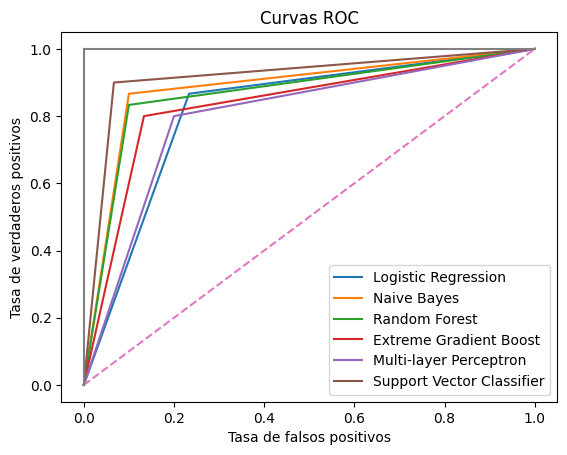

In [27]:
# representación de las curvas roc para todos los modelos calculados
lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,lr_predict)
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = roc_curve(y_test,nbpred)
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(y_test,rf_predicted)                                                             
xgb_false_positive_rate,xgb_true_positive_rate,xgb_threshold = roc_curve(y_test,xgb_predicted)
mlp_false_positive_rate,mlp_true_positive_rate,mlp_threshold = roc_curve(y_test,mlp_predicted)
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = roc_curve(y_test,svc_predicted)


plt.title('Curvas ROC')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(xgb_false_positive_rate,xgb_true_positive_rate,label='Extreme Gradient Boost')
plt.plot(mlp_false_positive_rate,mlp_true_positive_rate,label='Multi-layer Perceptron')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('Tasa de verdaderos positivos')
plt.xlabel('Tasa de falsos positivos')
plt.legend()
plt.show()

In [28]:
print(f'AUC-ROC Score for Logistic Regression: {roc_auc_score(y_test,lr_predict):.2f}')
print(f'AUC-ROC Score for Naive Bayes: {roc_auc_score(y_test,nbpred):.2f}')
print(f'AUC-ROC Score for Random Forest: {roc_auc_score(y_test,rf_predicted):.2f}')
print(f'AUC-ROC Score for Extreme Gradient Boost: {roc_auc_score(y_test,xgb_predicted):.2f}')
print(f'AUC-ROC Score for Multi-layer Perceptron: {roc_auc_score(y_test,mlp_predicted):.2f}')
print(f'AUC-ROC Score for Support Vector Classifier: {roc_auc_score(y_test,svc_predicted):.2f}')

AUC-ROC Score for Logistic Regression: 0.82
AUC-ROC Score for Naive Bayes: 0.88
AUC-ROC Score for Random Forest: 0.87
AUC-ROC Score for Extreme Gradient Boost: 0.83
AUC-ROC Score for Multi-layer Perceptron: 0.80
AUC-ROC Score for Support Vector Classifier: 0.92
